In [1]:
import torch
import torch.nn as nn

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
torch.cuda.is_available()

True

In [3]:
sns.get_dataset_names()

['anagrams',
 'anscombe',
 'attention',
 'brain_networks',
 'car_crashes',
 'diamonds',
 'dots',
 'exercise',
 'flights',
 'fmri',
 'gammas',
 'geyser',
 'iris',
 'mpg',
 'penguins',
 'planets',
 'tips',
 'titanic']

In [4]:
flight_data = sns.load_dataset("flights")
flight_data.head()

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


In [5]:
flight_data.shape


(144, 3)

In [6]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

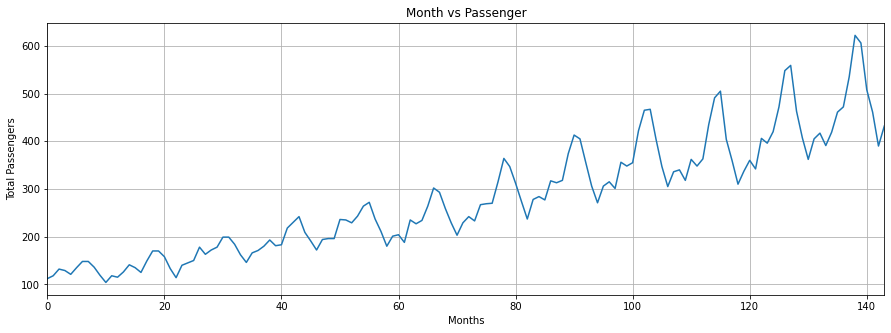

In [9]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.xlabel('Months')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(flight_data['passengers'])

In [10]:
flight_data.columns


Index(['year', 'month', 'passengers'], dtype='object')

In [11]:
all_data = flight_data['passengers'].values.astype(float)


In [12]:
all_data

array([112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
       118., 115., 126., 141., 135., 125., 149., 170., 170., 158., 133.,
       114., 140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
       162., 146., 166., 171., 180., 193., 181., 183., 218., 230., 242.,
       209., 191., 172., 194., 196., 196., 236., 235., 229., 243., 264.,
       272., 237., 211., 180., 201., 204., 188., 235., 227., 234., 264.,
       302., 293., 259., 229., 203., 229., 242., 233., 267., 269., 270.,
       315., 364., 347., 312., 274., 237., 278., 284., 277., 317., 313.,
       318., 374., 413., 405., 355., 306., 271., 306., 315., 301., 356.,
       348., 355., 422., 465., 467., 404., 347., 305., 336., 340., 318.,
       362., 348., 363., 435., 491., 505., 404., 359., 310., 337., 360.,
       342., 406., 396., 420., 472., 548., 559., 463., 407., 362., 405.,
       417., 391., 419., 461., 472., 535., 622., 606., 508., 461., 390.,
       432.])

In [13]:
test_data_size = 12

train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

In [17]:
len(train_data)

132

In [18]:
len(test_data)

12

In [19]:
import sklearn

ModuleNotFoundError: No module named 'sklearn'

In [20]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

In [23]:
len(train_data_normalized)

132

In [24]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)


In [26]:
train_data_normalized.size()

torch.Size([132])

In [29]:
train_window = 12

In [30]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [31]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)


In [35]:
np.shape(train_inout_seq[0])

(2,)

In [38]:
np.shape(train_inout_seq[0][0])

torch.Size([12])

In [39]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [40]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [41]:
print(model)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


In [50]:
epochs = 150

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.00033912
epoch:  26 loss: 0.00077531
epoch:  51 loss: 0.00524552
epoch:  76 loss: 0.00024205
epoch: 101 loss: 0.00008734
epoch: 126 loss: 0.00004579
epoch: 149 loss: 0.0001148836


In [51]:
fut_pred = 12

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

[0.12527473270893097, 0.04615384712815285, 0.3274725377559662, 0.2835164964199066, 0.3890109956264496, 0.6175824403762817, 0.9516483545303345, 1.0, 0.5780220031738281, 0.33186814188957214, 0.13406594097614288, 0.32307693362236023]


In [44]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

In [45]:
test_inputs[fut_pred:]


[0.7417742013931274,
 1.1354777812957764,
 1.3418405055999756,
 1.5129587650299072,
 1.61860191822052,
 1.6657392978668213,
 1.673707127571106,
 1.6589007377624512,
 1.6345216035842896,
 1.612442970275879,
 1.60104501247406,
 1.5978586673736572]

In [46]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions)

[[500.25363082]
 [589.82119524]
 [636.76871502]
 [675.69811904]
 [699.7319364 ]
 [710.45569026]
 [712.26837152]
 [708.89991784]
 [703.35366482]
 [698.33077574]
 [695.73774034]
 [695.01284683]]


In [47]:
x = np.arange(132, 144, 1)
print(x)

[132 133 134 135 136 137 138 139 140 141 142 143]


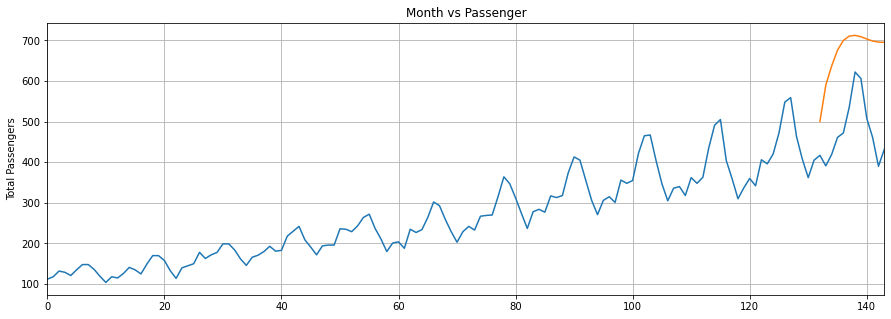

In [48]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(flight_data['passengers'])
plt.plot(x,actual_predictions)
plt.show()

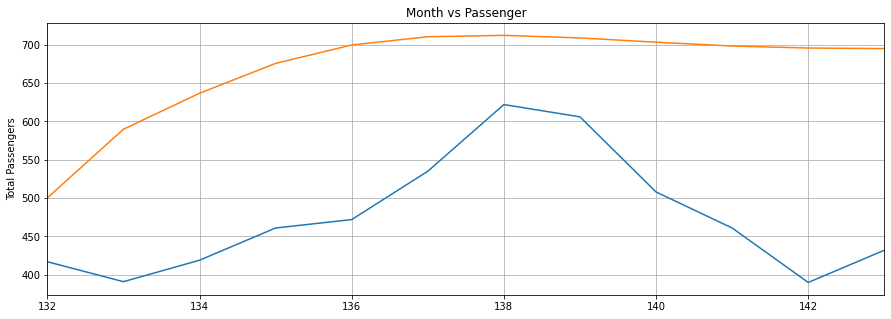

In [49]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(flight_data['passengers'][-train_window:])
plt.plot(x,actual_predictions)
plt.show()